In [1]:
import os
import pickle
from copy import deepcopy
from tqdm import tqdm
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import RandomSampler, TPESampler, GPSampler
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs you can use: {max_n_jobs}")
import shap

/Users/justpqa/Predict_NMXLNT/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Maximum n_jobs you can use: 12


In [2]:
df = pd.read_csv("NMXLNT_df.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
print(df["Location"].unique())
df.head()

['BAY MAU.csv' 'TU SON.csv' 'CAU NGA.csv' 'BTLVT.csv' 'YENSO.csv']


,cod_prev_4.0,cod_prev_5.0,cod_prev_6.0,cod_prev_7.0,cod_prev_8.0,cod_prev_9.0,cod_prev_10.0,cod_prev_11.0,cod_prev_4.5,cod_prev_5.5,...,nh4_prev_9.5,nh4_prev_10.5,nh4_prev_11.5,nh4_prev_12,sin_hour,sin_day,sin_month,cod,datetime,Location
0,25.33,25.19,24.98,24.71,24.35,23.98,23.48,23.07,25.24,25.09,...,0.9,0.89,0.88,0.89,1.224647e-16,0.201299,0.5,26.02,2024-01-01 12:05:00,BAY MAU.csv
1,25.36,25.17,25.02,24.73,24.38,24.00,23.50,23.15,25.26,25.10,...,0.9,0.89,0.89,0.89,1.224647e-16,0.201299,0.5,26.03,2024-01-01 12:10:00,BAY MAU.csv
2,25.37,25.18,25.04,24.76,24.44,24.04,23.55,23.21,25.32,25.13,...,0.9,0.89,0.89,0.89,1.224647e-16,0.201299,0.5,26.04,2024-01-01 12:15:00,BAY MAU.csv
3,25.36,25.19,25.06,24.78,24.47,24.08,23.59,23.27,25.33,25.15,...,0.9,0.90,0.89,0.88,1.224647e-16,0.201299,0.5,26.05,2024-01-01 12:20:00,BAY MAU.csv
4,25.39,25.21,25.07,24.77,24.50,24.08,23.62,23.32,25.33,25.16,...,0.9,0.90,0.89,0.88,1.224647e-16,0.201299,0.5,26.06,2024-01-01 12:25:00,BAY MAU.csv


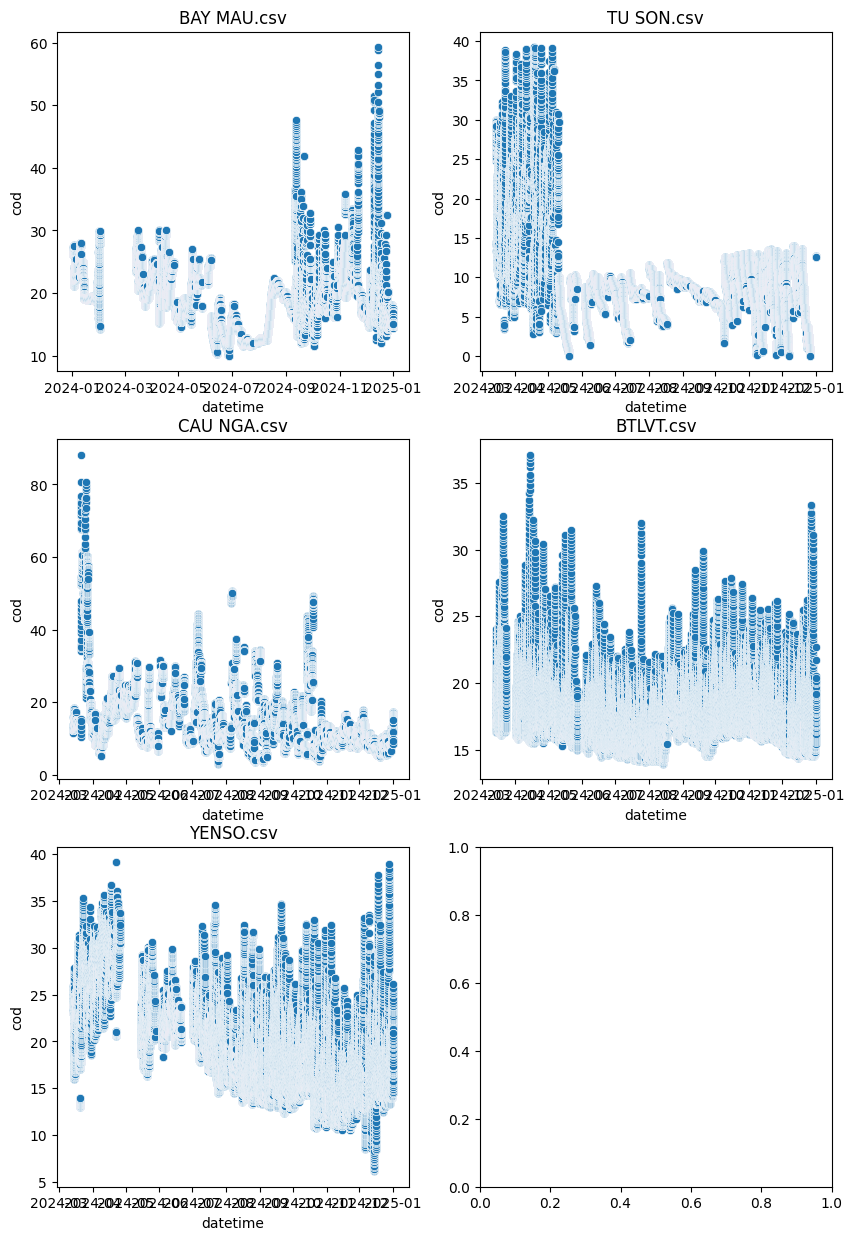

In [3]:
# try to plot cod against time in all data
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    x, y = inx // 2, inx % 2
    sns.scatterplot(df[df["Location"] == loc], x = "datetime", y = "cod", ax = ax[x][y])
    ax[x][y].set_title(loc)
plt.show()

Make CV split & compare with baseline

In [4]:
def create_cv_split(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_val(df, features_used, cv = 5):
    X_train_arr = []
    X_val_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_val_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i - 1].reset_index().drop("index", axis = 1))
        val = deepcopy(df[df["datetime"].dt.month == start_month + i - 1].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_val_arr.append(val[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_val_arr.append(val["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_val_arr, X_test_arr, Y_train_arr, Y_val_arr, Y_test_arr

def create_cv_split_location(df, features_used, loc, cv = 5):
    df = df[df["Location"] == loc].reset_index().drop("index", axis = 1)
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_diff(df, features_used, time_diff = 4, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train[f"cod_diff_{time_diff}"])
        Y_test_arr.append(test[f"cod_diff_{time_diff}"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_info(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    info_train_arr = []
    info_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
        info_train_arr.append(train[["datetime", "Location"]])
        info_test_arr.append((test[["datetime", "Location"]]))
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr

Make the model and finetune

In [5]:
default_n_trees = 200
default_random_state = 101
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log = True),
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), 
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0, 1), 
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0, 1), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        xgbr.fit(X_train, Y_train)
        Y_pred = xgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 2, 12), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True), 
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        lgbr.fit(X_train, Y_train)
        Y_pred = lgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True), 
        "depth": trial.suggest_int("depth", 2, 12), 
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        cbr.fit(X_train, Y_train)
        Y_pred = cbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

In [6]:
default_n_trials = 100
default_n_jobs = 1

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best MSE:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = TPESampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSLE:', study.best_value)
    return study.best_params

In [7]:
#### NOTE: All info about lags used will be saved here
time_fraction_used = [i/2 for i in range(2)]
lag_used = [round(i + t, 2) for t in time_fraction_used for i in range(4, 12)] + [12]

In [8]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                [f"flow_out_prev_{i}" for i in lag_used] + \
                [f"nh4_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
# features_used = [c for c in df.columns if "prev" in c and df[c].dtypes in ["int64", "float64"]]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# # baseline: using last k hours to predict
# baseline_score = 0
# for i in range(5):
#     baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
# baseline_score /= 5
# print(baseline_score)

# for loc in df["Location"].unique():
#     print(loc)
#     temp_df = deepcopy(df[df["Location"] == loc])
#     X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(temp_df, features_used)
#     for i in range(5):
#         print(i, np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2)))

# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [10]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{default_random_state}_{default_n_trees}_study", 
    f"xgboost_{default_random_state}_{default_n_trees}_study"
)
# best is 2.85 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)
# best is 2.81 (with remove of abnormal cod)
# best is 2.79 (adding regularization)
# best is 2.77 (after fixing)

[I 2025-06-22 01:14:30,501] Using an existing study with name 'xgboost_101_200_study' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-06-22 01:14:38,946] Trial 100 finished with value: 2.8188016264072706 and parameters: {'max_depth': 5, 'learning_rate': 0.022822070351675616, 'subsample': 0.33391041582450176, 'colsample_bytree': 0.8781487432860146, 'colsample_bynode': 0.33926847498887625, 'colsample_bylevel': 0.7841087834311055, 'min_child_weight': 6, 'reg_alpha': 35.38372990621882, 'reg_lambda': 71.22552904663023, 'gamma': 2.4143823333541543}. Best is trial 70 with value: 2.799435686698331.
[I 2025-06-22 01:14:47,491] Trial 101 finished with value: 2.823686810584938 and parameters: {'max_depth': 5, 'learning_rate': 0.01580263799848557, 'subsample': 0.2972395939494875, 'colsample_bytree': 0.9751906549643068, 'colsample_bynode': 0.5527600408943893, 'colsample_bylevel': 0.5484097149759946, 'min_child_weight': 9, 'reg_alpha': 20.744775222233407, 'reg_lambda': 91.98500999169254, 'gamma': 2.0499523864458054}. Best is trial 70 with value: 2.799435686698331.
[I 2025-06-22 01:14:54,726] Trial 102 finished with value: 

Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.02735802894826909, 'subsample': 0.05060545638250687, 'colsample_bytree': 0.7431360490730703, 'colsample_bynode': 0.999943365876185, 'colsample_bylevel': 0.892503537324591, 'min_child_weight': 5, 'reg_alpha': 77.58885450357526, 'reg_lambda': 95.3436801508903, 'gamma': 4.294635983671457}
Best RMSE: 2.7725952126069737


In [12]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{default_random_state}_{default_n_trees}_study", 
    f"lightgbm_{default_random_state}_{default_n_trees}_study",
) 
# best is 2.96 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)
# best is 2.784 (adding regularization)
# best is 2.775 (after fixing)

[I 2025-06-22 01:46:04,889] Using an existing study with name 'lightgbm_101_200_study' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-06-22 01:46:12,618] Trial 100 finished with value: 2.7842300462291627 and parameters: {'max_depth': 4, 'learning_rate': 0.033015111172361125, 'num_leaves': 893, 'subsample': 0.19973053959957607, 'colsample_bytree': 0.9642157266774869, 'min_child_weight': 0.14160013947355887, 'reg_alpha': 57.797437754249536, 'reg_lambda': 70.42760403857349}. Best is trial 90 with value: 2.780537556477215.
[I 2025-06-22 01:46:20,275] Trial 101 finished with value: 2.781571831061862 and parameters: {'max_depth': 4, 'learning_rate': 0.0326921889393969, 'num_leaves': 890, 'subsample': 0.20455997167845724, 'colsample_bytree': 0.9521555402978775, 'min_child_weight': 0.1486757707631882, 'reg_alpha': 56.74172598896952, 'reg_lambda': 75.2649034823455}. Best is trial 90 with value: 2.780537556477215.
[I 2025-06-22 01:46:27,868] Trial 102 finished with value: 2.7858431372458545 and parameters: {'max_depth': 4, 'learning_rate': 0.03381383995007457, 'num_leaves': 887, 'subsample': 0.20613216297687786, 'colsa

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.02552540851935744, 'num_leaves': 759, 'subsample': 0.12321967348081163, 'colsample_bytree': 0.8448052437482125, 'min_child_weight': 0.28572548632573064, 'reg_alpha': 16.98327414153021, 'reg_lambda': 99.72143743787139}
Best MSE: 2.775191433144605


In [ ]:
best_params_catboost = optimize_catboost(
    f"catboost_{default_random_state}_{default_n_trees}_study", 
    f"catboost_{default_random_state}_{default_n_trees}_study",
    objective_catboost
)
# best is this one, about 2.81 RMSE (with remove of very high cod)
# best is 2.859 (without remove of very high cod)
# best is 2.789 (adding regularization)

Analyze the range of best params

In [ ]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [ ]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.scatterplot(study_df, x = var, y = "value", ax = ax[x][y])
    plt.show()

In [ ]:
study_df = get_study_df("xgboost_101_200_study")
params_value_viz(study_df)

In [ ]:
study_df = get_study_df("lightgbm_101_200_study")
params_value_viz(study_df)

In [ ]:
study_df = get_study_df("catboost_101_200_study")
params_value_viz(study_df)

Testing on best configuration

In [ ]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [ ]:
def get_shap_values(model, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, sample_size=10000):
    mean_abs_shap_all = np.zeros(X_train_arr[0].shape[1])
    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        model.fit(X_train, Y_train)
        # X_test_sample = X_test.sample(sample_size, random_state = default_random_state)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        mean_abs_shap = np.mean(np.abs(shap_values), axis = 0)
        mean_abs_shap_all += mean_abs_shap
    mean_abs_shap_all /= 5
    return mean_abs_shap_all

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
# seems to pick up time features not as good as past 4 hours features

In [ ]:
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost = get_best_params_from_file(f"catboost_{default_random_state}_{default_n_trees}_study")
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

catboost_feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(catboost_feature_importances.values())
# can pick up a combination of both past cod and tss, not good at picking up ph, temp

In [ ]:
xgboost_feature_importances_df = pd.DataFrame(
    {"var": xgboost_feature_importances.keys(), "importance": xgboost_feature_importances.values()}
)
# xgboost_feature_importances_df["rank_importance"] = xgboost_feature_importances_df["importance"].rank(ascending=False)
lightgbm_feature_importances_df = pd.DataFrame(
    {"var": lightgbm_feature_importances.keys(), "importance": lightgbm_feature_importances.values()}
)
# lightgbm_feature_importances_df["rank_importance"] = lightgbm_feature_importances_df["importance"].rank(ascending=False)
catboost_feature_importances_df = pd.DataFrame(
    {"var": catboost_feature_importances.keys(), "importance_catboost": catboost_feature_importances.values()}
)
# catboost_feature_importances_df["rank_importance"] = catboost_feature_importances_df["importance_catboost"].rank(ascending=False)
feature_importances_df = xgboost_feature_importances_df.merge(
    lightgbm_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("_xgboost", "_lightgbm")
)
feature_importances_df = feature_importances_df.merge(
    catboost_feature_importances_df,
    on="var",
    how="inner",
    suffixes=("", "_catboost")
)
# feature_importances_df = feature_importances_df[["var", "rank_importance_xgboost", "rank_importance_lightgbm", "rank_importance_catboost"]]
# feature_importances_df["rank"] = 1/3 * (feature_importances_df["rank_importance_xgboost"] + feature_importances_df["rank_importance_lightgbm"] + feature_importances_df["rank_importance_catboost"])
feature_importances_df["importance"] = 1/3 * (feature_importances_df["importance_xgboost"] + feature_importances_df["importance_lightgbm"] + feature_importances_df["importance_catboost"])
feature_importances_df = feature_importances_df.sort_values(by="importance", ascending=False).reset_index().drop("index", axis = 1)
feature_importances_df

In [ ]:
plt.hist(feature_importances_df["importance"])

In [ ]:
sns.scatterplot(data = feature_importances_df.reset_index(), x = "index", y = "importance")

In [ ]:
feature_importances_df.to_csv("feature_importance_df.csv", index = False)

Get feature importance

In [ ]:
feature_importances_df = pd.read_csv("feature_importance_df.csv")
feature_importances_df

In [ ]:
feature_importances_df.loc[:30, ]

#### Try to train best combination

XGBoost

In [ ]:
feature_importances_df.sort_values("importance_xgboost", ascending=False).reset_index().drop("index", axis = 1).loc[:20,]

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["ph_prev_4"] + \
                ["tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_xgboost_best_comb = optimize_xgboost(
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb",
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb",
)


In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_best_comb = get_best_params_from_file(f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_xgboost_best_comb:
    params[p] = best_params_xgboost_best_comb[p]

xgboost_feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = get_shap_values(xgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        xgboost_feature_importances[feat] = xgboost_feature_importances.get(feat, 0) + features_i[inx]

# print(feature_importances)
plt.hist(xgboost_feature_importances.values())
xgboost_feature_importances

LightGBM

In [ ]:
# feature_importances_df.sort_values("importance_lightgbm", ascending=False).reset_index().drop("index", axis = 1).loc[:20, "var"].tolist()

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_lightgbm_best_comb = optimize_lightgbm(
    f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb",
    f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb"
) 

In [ ]:
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_best_comb = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_lightgbm_best_comb:
    params[p] = best_params_lightgbm_best_comb[p]

lightgbm_feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = get_shap_values(lgbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        lightgbm_feature_importances[feat] = lightgbm_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(lightgbm_feature_importances.values())
lightgbm_feature_importances

Catboost

In [ ]:
# feature_importances_df.sort_values("importance_catboost", ascending=False).reset_index().drop("index", axis = 1).loc[:20, "var"].tolist()

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"] # keep this when you try to run tomorrow

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_catboost_best_comb = optimize_catboost(
    f"catboost_study_{default_random_state}_{default_n_trees}_best_comb",
    f"catboost_study_{default_random_state}_{default_n_trees}_best_comb"
)

In [ ]:
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost_best_comb = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_catboost_best_comb:
    params[p] = best_params_catboost_best_comb[p]

catboost_feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = get_shap_values(cbr, X_train_arr, X_test_arr, Y_train_arr, Y_test_arr)
    for inx, feat in enumerate(features):
        catboost_feature_importances[feat] = catboost_feature_importances.get(feat, 0) + features_i[inx]

plt.hist(catboost_feature_importances.values())

#### Try to be more truncated

XGBoost

In [ ]:
temp = feature_importances_df.sort_values("importance_xgboost", ascending=False).reset_index().drop("index", axis = 1)
sns.scatterplot(data = temp.reset_index(), x = "index", y = "importance_xgboost")
k = 10
plt.axvline(x = k, color = "red")
temp.loc[:k,]

In [ ]:
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 6, 7, 11.5, 12]] + \
                ["sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_xgboost_best_comb_truncated = optimize_xgboost(
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_truncated",
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_truncated",
)
# slightly worse ?

#### Try to extend instead

XGBoost

In [ ]:
temp = feature_importances_df.sort_values("importance_xgboost", ascending=False).reset_index().drop("index", axis = 1)
sns.scatterplot(data = temp.reset_index(), x = "index", y = "importance_xgboost")
k = 30
plt.axvline(x = k, color = "red")
temp.loc[:k,]

In [ ]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in [4, 4.5, 5]] + \
                [f"tss_prev_{i}" for i in [4, 4.5]] + \
                [f"temp_prev_{i}" for i in [4, 11, 11.5, 12]] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [ ]:
best_params_xgboost_best_comb_extended = optimize_xgboost(
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_extended",
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_extended",
)

Combine all 3 models

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

# train list of models
xgbr_arr = [XGBRegressor(**params)] * 5
Y_pred_xgboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr_arr[i].fit(X_train, Y_train)
    Y_pred_xgboost_arr.append(xgbr_arr[i].predict(X_test))

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 8.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_lightgbm = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

# train list of models
lgbr_arr = [LGBMRegressor(**params)] * 5
Y_pred_lightgbm_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr_arr[i].fit(X_train, Y_train)
    Y_pred_lightgbm_arr.append(lgbr_arr[i].predict(X_test))

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_catboost = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

# train list of models
cbr_arr = [CatBoostRegressor(**params)] * 5
Y_pred_catboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    cbr_arr[i].fit(X_train, Y_train)
    Y_pred_catboost_arr.append(cbr_arr[i].predict(X_test))

In [ ]:
best_cv_rmse = float("inf")
best_alpha = -1
best_beta = -1
for alpha in tqdm([0.01 * k for k in range(101)]):
    for beta in [0.01 * l for l in range(101)]:
        cv_rmse = 0
        for i in range(5):
            Y_pred =  alpha * Y_pred_catboost_arr[i] + (1 - alpha) * beta * Y_pred_lightgbm_arr[i] + (1 - alpha) * (1 - beta) * Y_pred_xgboost_arr[i]
            rmse = root_mean_squared_error(Y_test_arr[i], Y_pred)
            cv_rmse += rmse
        cv_rmse /= 5
        if cv_rmse < best_cv_rmse:
            best_cv_rmse = cv_rmse 
            best_alpha = alpha
            best_beta = beta
print(best_alpha, best_beta, best_cv_rmse)

In [ ]:
best_cv_rmse = float("inf")
best_alpha = -1
for alpha in tqdm([0.01 * k for k in range(101)]):
    cv_rmse = 0
    for i in range(5):
        Y_pred =  alpha * Y_pred_catboost_arr[i] + (1 - alpha) * Y_pred_xgboost_arr[i]
        rmse = root_mean_squared_error(Y_test_arr[i], Y_pred)
        cv_rmse += rmse
    cv_rmse /= 5
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse 
        best_alpha = alpha
print(best_alpha, best_cv_rmse)

Train model with best config on all data

In [ ]:
def split(df, features_used):
    X = df[features_used]
    Y = df["cod"]
    return X, Y

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
X, Y = split(df, features_used)

# get best model params
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
params = {
    "n_estimators": default_n_trees,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

# train list of models
xgbr = XGBRegressor(**params)
xgbr.fit(X, Y)
with open(f'model/xgboost_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(xgbr, f)

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 8.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X, Y = split(df, features_used)

# get best model params
best_params_lightgbm = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "n_estimators": default_n_trees,
    "verbosity": -1,
    "random_state": default_random_state
}
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

# train list of models
lgbr = LGBMRegressor(**params)
lgbr.fit(X, Y)
with open(f'model/lightgbm_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(lgbr, f)

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]
X, Y = split(df, features_used)

# get best model params
best_params_catboost = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "iterations": default_n_trees,
    "verbose": False,
    "random_seed": default_random_state
}
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

# train list of models
cbr = CatBoostRegressor(**params)
cbr.fit(X, Y)
with open(f'model/catboost_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(cbr, f)